# Task 1: Pricing

Our marketing manager was surveying the willingness to buy one of our fashion items at a
certain price. They discovered the demand quantities, i.e. the number of people willing to buy,
at various price levels. We have them below in two arrays.

`Please find out the optimal price that maximises revenue.`

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize, Bounds
from scipy.interpolate import interp1d
from typing import List

In [2]:
pricing = pd.DataFrame({
'prices': [100, 90, 70, 60, 40, 20, 10],
'demand': [100, 120, 200, 300, 1200, 2000, 2800]
})

The first step I like to take on data analytics problems is to visualize the data. So after pasting the given pandas dataframe, I print the table.

In [3]:
pricing

,prices,demand
0,100,100
1,90,120
2,70,200
3,60,300
4,40,1200
5,20,2000
6,10,2800


Because we want to maximize revenue, I directly from within the dataframe generate another column called `revenue` that multiplies `prices` and `demand`

In [4]:
pricing["revenue"] = pricing["prices"] * pricing["demand"]
pricing

,prices,demand,revenue
0,100,100,10000
1,90,120,10800
2,70,200,14000
3,60,300,18000
4,40,1200,48000
5,20,2000,40000
6,10,2800,28000


Then, I plug in the values an generate a graph to see the relationship between `princing` and `revenue`.

Text(0.5, 1.0, 'demand vs revenue')

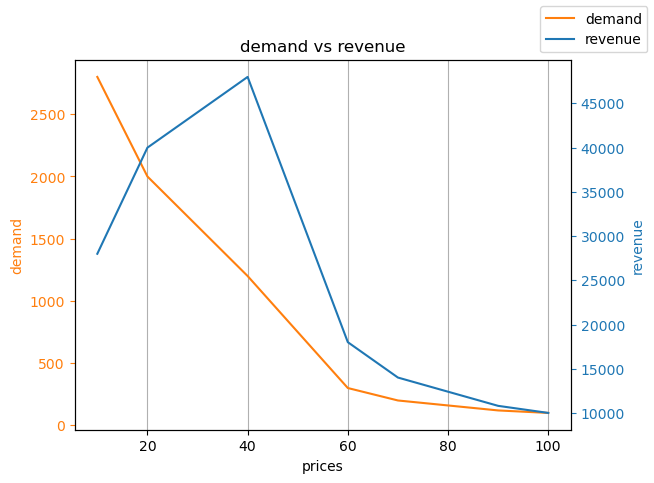

In [5]:
color1 = "tab:orange"
color2 = "tab:blue"

fig, ax1 = plt.subplots()
ax1.plot(pricing["prices"], pricing["demand"], label="demand", color=color1)

ax1.set_xlabel(pricing.columns[0])
ax1.set_ylabel(pricing.columns[1])
ax1.xaxis.grid() # vertical lines
ax1.yaxis.label.set_color(color1)
ax1.tick_params(axis='y', colors=color1)

ax2 = ax1.twinx()
ax2.plot(pricing["prices"], pricing["revenue"], label="revenue", color=color2)
ax2.set_ylabel(pricing.columns[2])
ax2.yaxis.label.set_color(color2)
ax2.tick_params(axis='y', colors=color2)

fig.legend()

ax1.set_title("demand vs revenue")

# TODO: put colors on the lines
# elbow method!!!



By looking at the data there seems to be a "crest" missing to the right of the 40 euro mark. We could choose only to have that value, in case these are the prices set up by marketing, for whatever reason. Maybe there is a solution similar to the customer attraction to thos number decided by marketing? (similar to why it is mostly posted as 9.99 instead of 10)

But we continue further the analysis to determine the optimal value

### Method 1

As a first approach, I decided to try fitting a polynomial into the data to try to find this solution. After some experimentation, a general polynomail of degree 5 fitted the graph well. It is worth noting here though, that only this curve is shown between the boundaries [10, 100]. 

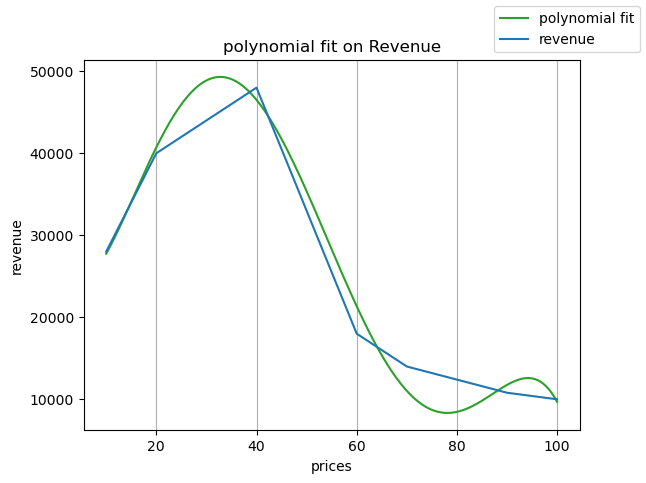

In [6]:
z = np.polyfit(pricing["prices"], pricing["revenue"], 5)
p = np.poly1d(z) 
xp = np.linspace(10, 100, 200)


fig, ax1 = plt.subplots()
ax1.plot(xp, p(xp), label="polynomial fit", c="tab:green")
ax1.xaxis.grid() # vertical lines
ax1.set_xlabel(pricing.columns[0])
ax1.set_ylabel(pricing.columns[2])
ax1.plot(pricing["prices"], pricing["revenue"], label="revenue", color="tab:blue")

ax1.set_title("polynomial fit on Revenue")

fig.legend()


The polynomial that best fits the data in this boundaries is:

In [7]:
print(p)

            5           4         3         2
-0.0002794 x + 0.07301 x - 6.438 x + 204.9 x - 1352 x + 2.652e+04


After that, it is only a matter of pasting it as the objective formula of a bounded maximization problem (note the `-p` in the function call). 

In [8]:
res = minimize(-p, 20, bounds=Bounds(10,100))
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -49309.28450823987
        x: [ 3.278e+01]
      nit: 5
      jac: [-1.455e-03]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

The result of the optimization is then:

In [9]:
res["x"][0]

32.78100550915721

The complete method given the objective of the assignment, then becomes:

In [10]:
def revenue_maximizing_price(prices:pd.Series, demand:pd.Series) -> float:
    
    revenue = prices * demand

    poly_function = np.polyfit(prices, revenue, 5)
    p = np.poly1d(poly_function) # numpy convenience function to work with polyfit
    res = minimize(-p, 20, bounds=Bounds(10,100))

    return float(res["x"][0])

revenue_maximizing_price(pricing["prices"], pricing["demand"])

32.78100550915721

### Method 2

For an alternate method I decided to try to iterpolate the values using the scipy's interp1d function in a quadratic approximation:

In [11]:
interp_func = interp1d(pricing['prices'], pricing['revenue'], kind='quadratic', fill_value='extrapolate')

If I then plug this formula into the data that we have available, we can see that the "crest" is well approximated:

Text(0.5, 1.0, 'Quadratic interpolation on Revenue')

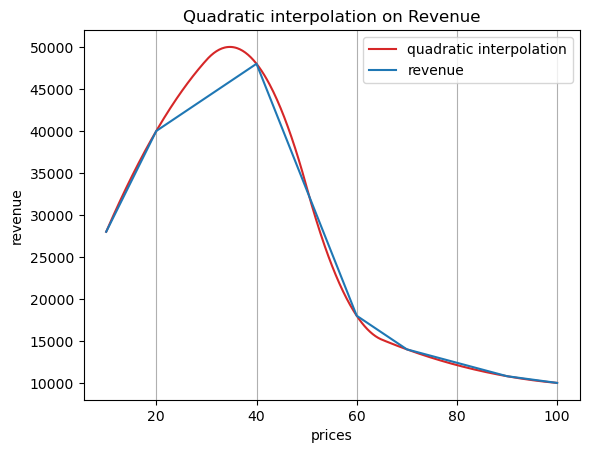

In [12]:
xp = np.linspace(10, 100, 500)

fig, ax1 = plt.subplots()
ax1.plot(xp, interp_func(xp), label="quadratic interpolation", c="tab:red")
ax1.xaxis.grid() # vertical lines
ax1.set_xlabel(pricing.columns[0])
ax1.set_ylabel(pricing.columns[2])
ax1.plot(pricing["prices"], pricing["revenue"], label="revenue", color="tab:blue")
ax1.legend()

ax1.set_title("Quadratic interpolation on Revenue")

Instead of doing calling again the `minimize` formula, I just rely on numpy's `argmax` function, that will give me price for the highest revenue on a list with a resolution that was considered enough for this problem:

In [13]:
xp[interp_func(xp).argmax()]

34.70941883767536

And so, the complete function for the second method would look like this:

In [14]:
def revenue_maximizing_price(prices:pd.Series, demand:pd.Series) -> float:
    
    revenue = prices * demand

    interp_func = interp1d(prices, revenue, kind="quadratic", fill_value="extrapolate")

    xp = np.linspace(10, 100, 500)
    return xp[interp_func(xp).argmax()]

revenue_maximizing_price(pricing["prices"], pricing["demand"])

34.70941883767536

### Further observations

1. single function called `revenue_maximizing_price` was given as requirement in the assignment but should not be used to generalize data. This was part of an ad-hoc investigation and other data with other structures might require different investigations.
2. The two results of the exercise gave 32.78 and 34.70. I would recommend the marketing manager to select 33.74, the average of both. 
3. This exploration only is used to maximize revenue. No assumptions on cost were taken into account.

In [15]:
(32.78 + 34.71)/2

33.745000000000005